Base classification of the model using resnet50. In this notebook the images were classified using the Resnet algorithm. The model was experiment with different Hyperparameters  and accuracy was coming around 97% for the classification .. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches
import random
import os
import tensorflow
tensorflow.__version__

!pip install pydicom
import pydicom as dcm
%matplotlib inline 
IS_LOCAL = False

import pandas as pd
import numpy as np

     |████████████████████████████████| 1.9MB 5.6MB/s 


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Capstone')

LOAD Dataset

In [ ]:
train_detail = pd.read_csv('/content/drive/MyDrive/Capstone/stage_2_detailed_class_info.csv')
train_label = pd.read_csv('/content/drive/MyDrive/Capstone/stage_2_train_labels1.csv')

In [ ]:
train_detail.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
train_label.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
print('Shape of Detailed Class Information: {}'.format(train_detail.shape))
print('Shape of Train Labels: {}'.format(train_label.shape))

Shape of Detailed Class Information: (30227, 2)
Shape of Train Labels: (30227, 6)


MERGE the Data

In [ ]:
merge_train_df = train_label.merge(train_detail, left_on='patientId', right_on='patientId', how='inner')
merge_train_df.sample(5)

,patientId,x,y,width,height,Target,class
33292,ee5842e0-5bd3-4e4b-9aea-cb94b6402fdb,636.0,552.0,172.0,200.0,1,Lung Opacity
11831,6651fcff-b4af-4ab7-8c41-56ddeb931d9e,NaN,NaN,NaN,NaN,0,Normal
17923,8e1b4918-def3-42df-a2cc-d0f071f42051,533.0,185.0,297.0,665.0,1,Lung Opacity
31876,e47221dd-dfa3-40b0-8b73-1f7fd8ae4a80,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
35291,fbea2dbf-3828-4b0b-a8cf-e1a1e513851b,610.0,326.0,225.0,332.0,1,Lung Opacity


Handling value using KNN imputer.

In [ ]:
merge_bb_df = merge_train_df.drop(columns = ["patientId", "class"])

## Impute NaN with KNN mean
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
merge_bb_imputed_df = imputer.fit_transform(merge_bb_df)

## Converted array to dataframe
merge_bb_final = pd.DataFrame(data=merge_bb_imputed_df, columns=["x", "y", "width", "height", "Target"])
merge_bb_final["Target"] = merge_bb_final["Target"].astype('int64')
merge_bb_final.head(-5)

,x,y,width,height,Target
0,264.0,152.0,213.0,379.0,0
1,264.0,152.0,213.0,379.0,0
2,264.0,152.0,213.0,379.0,0
3,264.0,152.0,213.0,379.0,0
4,264.0,152.0,213.0,379.0,1


In [ ]:
merge_bb_final.head(-5)

,x,y,width,height,Target
0,264.0,152.0,213.0,379.0,0
1,264.0,152.0,213.0,379.0,0
2,264.0,152.0,213.0,379.0,0
3,264.0,152.0,213.0,379.0,0
4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...
37619,609.0,464.0,240.0,284.0,1
37620,609.0,464.0,240.0,284.0,1
37621,185.0,298.0,228.0,379.0,1
37622,185.0,298.0,228.0,379.0,1


Split Data

In [ ]:
tmp = merge_train_df[["patientId", "class"]]
train_labels_data = pd.merge(tmp, merge_bb_final, how= 'inner', left_index=True, right_index=True)
train_labels_data.head(-10)

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,264.0,152.0,213.0,379.0,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,264.0,152.0,213.0,379.0,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,264.0,152.0,213.0,379.0,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,264.0,152.0,213.0,379.0,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...,...
37614,c1e3eb82-c55a-471f-a57f-fe1a823469da,Normal,264.0,152.0,213.0,379.0,0
37615,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity,666.0,418.0,186.0,223.0,1
37616,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity,666.0,418.0,186.0,223.0,1
37617,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity,316.0,504.0,179.0,273.0,1


In [ ]:
X = train_labels_data.drop(columns= ["patientId", "Target", "class"])
y = train_labels_data[["Target"]]
X.shape, y.shape

((37629, 4), (37629, 1))

In [ ]:
X.shape, y.shape
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
from sklearn.metrics import roc_auc_score, auc, plot_confusion_matrix, plot_roc_curve, roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =7)
print('Training data shape:', (X_train.shape, y_train.shape))
print('Test data shape:', (X_test.shape, y_test.shape))

Training data shape: ((30103, 4), (30103, 1))
Test data shape: ((7526, 4), (7526, 1))


**Base Classification**

Modelling

In [ ]:
import os
import csv
import random
import pydicom
import numpy as np
import pandas as pd
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

In [ ]:
PATH = '/content/drive/MyDrive/Capstone'

In [ ]:
opacity_locations = {}
# load table
with open(os.path.join(PATH+'/stage_2_train_labels1.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        #print(reader)
        filename = rows[0]
        #print(filename)
        location = rows[1:5]
        #print(location)
        pneumonia = rows[5]
        #print(pneumonia)
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in opacity_locations:
                opacity_locations[filename].append(location)
            else:
                opacity_locations[filename] = [location]
        

In [ ]:
# load and shuffle filenames
folder = '/content/drive/MyDrive/Capstone/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


In [ ]:
!pip install opencv-python
import cv2
keras = tf.compat.v1.keras
#Sequence = keras.utils.Sequence

In [ ]:
class generatortransfer(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, opacity_locations=None, batch_size=32, image_size=320, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.opacity_locations = opacity_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains lung opacity
        if filename in opacity_locations:
            # loop through opacity
            for location in opacity_locations[filename]:
                # add 1's at the location of the lung opacity
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        #img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        msk = np.expand_dims(msk, -1)
         #Converting Image from GrayScale to RGB 
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
            img = cv2.resize(img, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        #img = resize(img, (self.image_size, self.image_size), mode='reflect')
        #Converting Image from GrayScale to RGB 
        if len(img.shape) != 3 or img.shape[2] != 3:
          img = np.stack((img,) * 3, -1)
          img = cv2.resize(img, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [ ]:
img_width = 128
img_height = 128
IMAGE_SIZE=128
kernel =3
num_of_classes =2
BATCH_SIZE = 16
SHUFFLE_BUFFER_SIZE=1000

In [ ]:
folder = '/content/drive/MyDrive/Capstone/stage_2_train_images'
train_trans = generatortransfer(folder, train_filenames, opacity_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False)
valid_trans = generatortransfer(folder, valid_filenames, opacity_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

In [ ]:
import keras
from tensorflow.keras import Sequential, backend as K
#from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(ResNet50(input_shape= (img_width, img_height, 3), include_top=False, weights='imagenet'))
model.add(Dense(1024, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(512, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(256, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(64, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(8, activation='relu'))
model.add(UpSampling2D())
model.add(Dense(1, activation='sigmoid'))
# Say not to train first layer (ResNet) model. It is already trained
model.layers[0].trainable = False
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dense_6 (Dense)              (None, 4, 4, 1024)        2098176   
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 8, 8, 1024)        0         
_________________________________________________________________
dense_7 (Dense)              (None, 8, 8, 512)         524800    
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 16, 16, 512)       0         
_________________________________________________________________
dense_8 (Dense)              (None, 16, 16, 256)       131328    
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 32, 32, 256)      

In [ ]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_trans, epochs=2, steps_per_epoch =10, shuffle=True)

Epoch 1/2
10/10 [==============================] - 76s 7s/step - loss: 0.5040 - accuracy: 0.7143
Epoch 2/2
10/10 [==============================] - 68s 7s/step - loss: 0.1563 - accuracy: 0.9590


In [ ]:
model.evaluate(valid_trans)

160/160 [==============================] - 785s 5s/step - loss: 0.1193 - accuracy: 0.9730


[0.1192963570356369, 0.9729534387588501]

**Train with More Hyper parameters**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
## Earlystopping
earlystop = EarlyStopping(monitor='val_loss', patience=3)

## Model Check point

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)

weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

## Reduce learning rate when metric has stopped improving
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=2, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential, backend as K
#from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

hpt_model = Sequential()
hpt_model.add(ResNet50(input_shape= (img_width, img_height, 3), include_top=False, weights='imagenet'))
hpt_model.add(Dense(1024, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(512, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(256, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(64, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(8, activation='relu'))
hpt_model.add(UpSampling2D())
hpt_model.add(Dense(1, activation='sigmoid'))
# Say not to train first layer (ResNet) model. It is already trained
hpt_model.layers[0].trainable = False
print(hpt_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dense_12 (Dense)             (None, 4, 4, 1024)        2098176   
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 8, 8, 1024)        0         
_________________________________________________________________
dense_13 (Dense)             (None, 8, 8, 512)         524800    
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 16, 16, 512)       0         
_________________________________________________________________
dense_14 (Dense)             (None, 16, 16, 256)       131328    
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 32, 32, 256)      

In [ ]:
hpt_model.compile(optimizer= 'Adam',
              loss='binary_crossentropy',
              metrics=['accuracy', mean_iou])

In [ ]:
#history = hpt_model.fit_generator(train_trans,validation_data=valid_trans, 
#                        callbacks=[earlystop,checkpoint, reduceLROnPlat],epochs=2, workers=4, use_multiprocessing=True)

In [ ]:
history = hpt_model.fit(train_trans, epochs=2, steps_per_epoch =10, shuffle=True, 
                        callbacks=[earlystop,checkpoint, reduceLROnPlat,],validation_freq=1)

Epoch 1/2
10/10 [==============================] - 73s 7s/step - loss: 0.4613 - accuracy: 0.7115 - mean_iou: 0.5603
Epoch 2/2
10/10 [==============================] - 69s 7s/step - loss: 0.1229 - accuracy: 0.9736 - mean_iou: 0.7994


In [ ]:
model.save_weights('RESNET50-FEB.hdf5')

PREDICT the TEST IMAGES

In [ ]:
# load and shuffle filenames
#folder = '../input/stage_2_test_images'
folder = '/content/drive/MyDrive/Capstone/stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

n test samples: 3000


In [ ]:
# create test generator with predict flag set to True
test_trans = generatortransfer(folder, test_filenames, None, batch_size=16, image_size=IMAGE_SIZE, shuffle=False, predict=True)

In [ ]:
test_dicom_dir =  '/content/drive/MyDrive/Capstone/stage_2_test_images'

In [ ]:
import glob
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

In [ ]:
import glob
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

In [ ]:
test_image_fps = get_dicom_fps(test_dicom_dir)

In [ ]:
image_size = 128
import pydicom
import numpy  
import gc
import csv
from datetime import datetime
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
# Make predictions on test images, write out sample submission 
#def predict(image_fps, filepath=None, min_conf=0.98): 
    
    # assume square image
    
#    with open(filepath, 'w') as file:
#      for image_id in tqdm_notebook(image_fps): 
image_id = test_image_fps[1]
ds = dcm.read_file(image_id)
image = ds.pixel_array
print(image.shape)          
        # If grayscale. Convert to RGB for consistency.
        #if len(image.shape) != 3 or image.shape[2] != 3:

        #print(img)
image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
image = np.stack((image,)*3, axis=-1)
print(image.shape)
image = preprocess_input(np.array(image, dtype=np.float32))
#print(image)
        
results = model.predict(np.expand_dims(image, axis=0))[0]
print(image.shape)
r = results[0]
r1=np.argmax(results,axis=1)
print(image_id)

(1024, 1024)
(128, 128, 3)
(128, 128, 3)
/content/drive/MyDrive/Capstone/stage_2_test_images/2a71e8d0-6da9-4cb8-b31e-1dc8a530ea91.dcm


In [ ]:
len(r1)

128

In [ ]:
results.shape

(128, 128, 1)

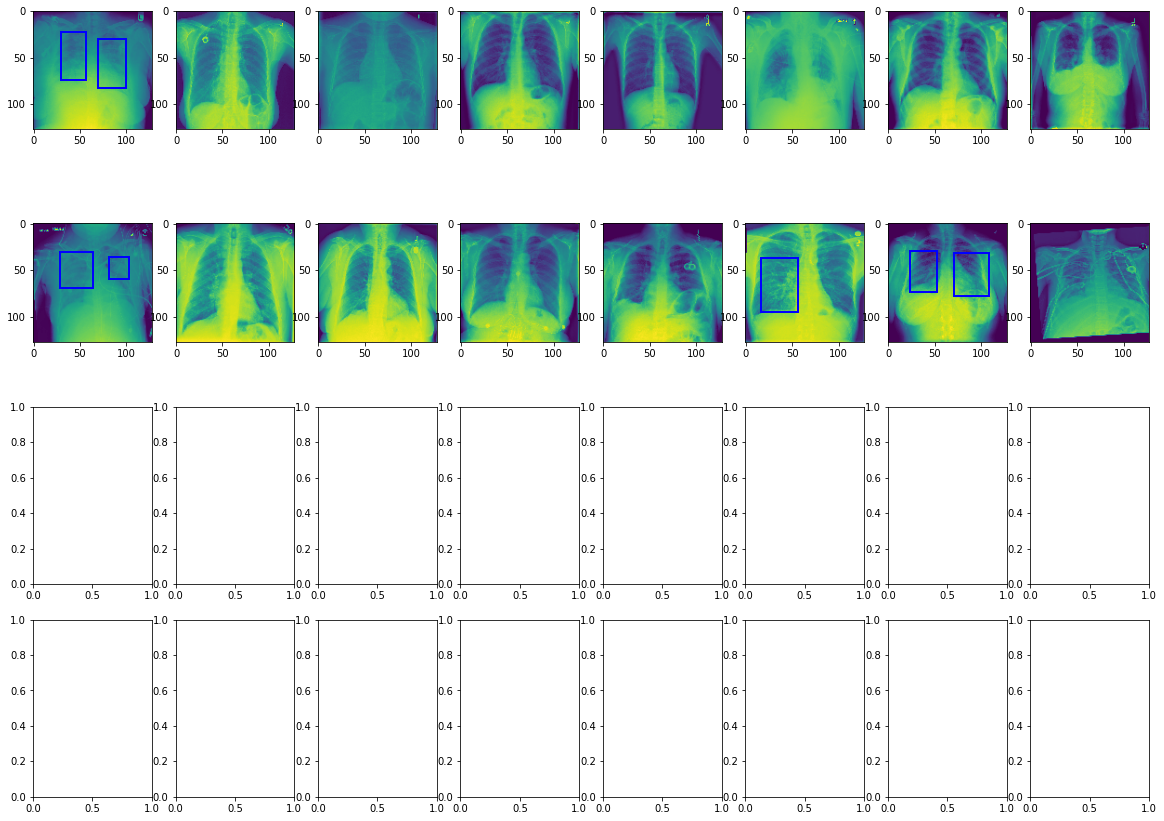

In [ ]:
i=0
for imgs, msks in valid_trans:    
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        i=i+1
        #exit after 32 images
        if i>32:
            break
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        #print(msk)
        #print(img)
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        axidx += 1
    plt.show()
    # only plot one batch
    break